In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import geopandas
import random
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from progressbar import ProgressBar
import time

## This notebook computes the number of GRDC runoff stations per basin

Import basins data, with approximate Koppen-Geiger climate zones if `approximate` is `True`.

In [13]:
approximate=False
if approximate:
    basins=geopandas.read_file("../datasets/basins/basins_with_approx_climate_zones.shp")
else:
    basins=geopandas.read_file("../datasets/basins/basins_with_climate_zones.shp")
basins.set_index("CATCH_ID",inplace=True)
basins.columns=['NAME', 'RASTAREA', 'DB_ID', 'SORTING', 'LATITUDE', 'MAIN_CLIMATE', 'CLIMATE_AREA_%',
    'COLOR','geometry']
basins.crs = 'epsg:4326'
Nbasins=basins.shape[0]

Import runoff stations downloaded on [GRDC website](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html)

In [4]:
GRDC=pd.read_excel("../datasets/other/GRDC_Stations.xlsx",index_col=[0])
GRDC.head()

,wmo_reg,sub_reg,river,station,country,lat,long,area,altitude,d_start,...,m_start,m_end,m_yrs,m_miss,t_start,t_end,t_yrs,lta_discharge,r_volume_yr,r_height_yr
grdc_no,,,,,,,,,,,,,,,,,,,,,
1104150,1,4,"CHELIF, OUED",SIDI BELATAR,DZ,36.02,0.27,43750.0,2.0,1978.0,...,1976.0,1977.0,2.0,0.0,1976,2001,26,15.027,0.473891,10.8318
1104200,1,4,"MINA, OUED",OUED EL-ABTAL,DZ,35.50,0.68,6635.0,205.0,NaN,...,1976.0,1978.0,3.0,0.0,1976,1978,3,2.578,0.0812998,12.2532
1104300,1,4,"GHIOU, OUED",AMMI MOUSSA,DZ,35.87,1.12,2398.0,140.0,NaN,...,1976.0,1979.0,4.0,0.0,1976,1979,4,3.195,0.100758,42.0173
1104450,1,4,"MAZAFRAN, OUED",FER A CHEVAL,DZ,36.67,2.82,1912.0,10.0,1979.0,...,1976.0,1978.0,3.0,0.0,1976,1995,20,3.379,0.10656,55.7323
1104480,1,4,"BOU DOUAOU, OUED",KEDDARA,DZ,36.65,3.42,829.0,60.0,NaN,...,1976.0,1979.0,4.0,0.0,1976,1979,4,0.354,0.0111637,13.4665


Select stations that operated at least 1 year between 2003 and 2017.

In [5]:
year1=2003
year2=2017
GRDC_select=GRDC.loc[(GRDC['t_end']>year1)&(GRDC['t_start']<=year2)]
# add points with coordinates
df=pd.DataFrame({'x':GRDC_select['long'],'y':GRDC_select['lat']})
GRDC_points=geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))
GRDC_points.crs='epsg:4326'

Nstations=GRDC_points.shape[0]
print("{} runoff stations operated between {} and {}".format(Nstations,year1,year2))

4865 runoff stations operated between 2003 and 2017


<IPython.core.display.Javascript object>


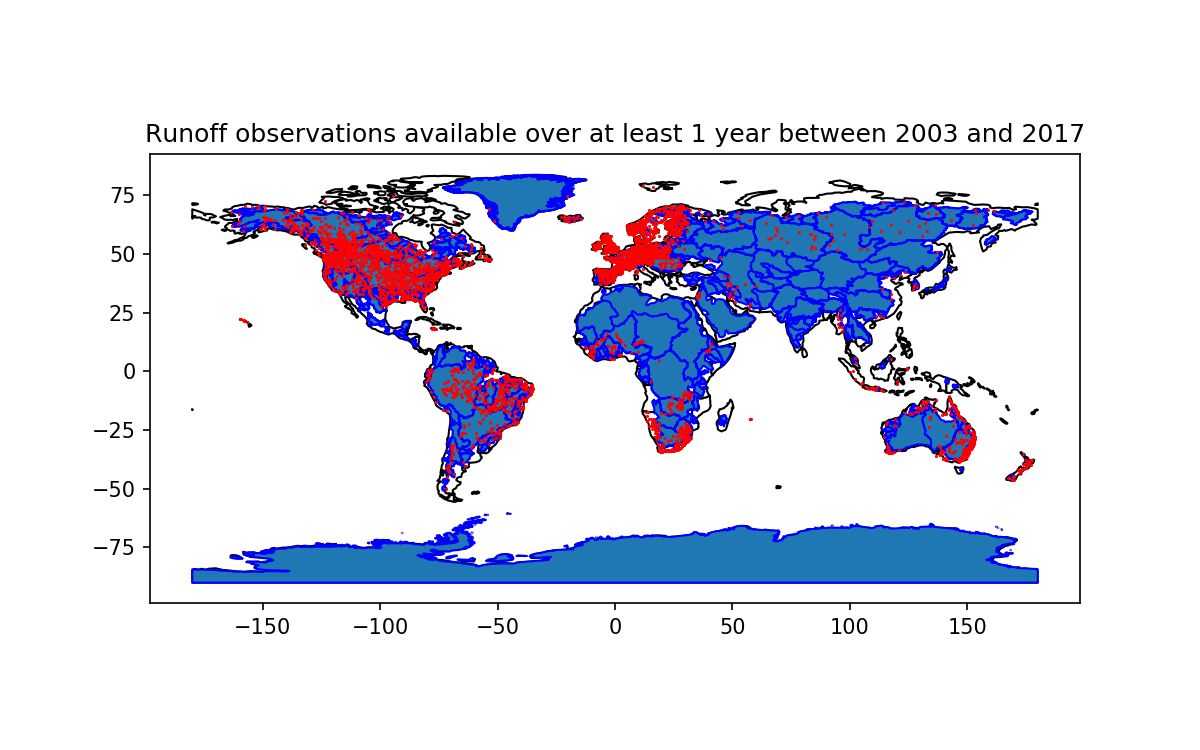

In [6]:
%matplotlib notebook
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.plot(ax=ax, edgecolor='blue')
GRDC_points.plot(ax=ax,marker='.',markersize=1,color='red')
plt.title("Runoff observations available over at least 1 year between {} and {}".format(year1,year2))
plt.show()

For each selected station, we compute its distance to all basins (distance is zero if the station is inside a basin).

In [7]:
# we project datasets in meter projection
basins_meter=basins.copy()
basins_meter=basins_meter.to_crs('epsg:6933')
GRDC_meter=GRDC_points.copy()
GRDC_meter=GRDC_meter.to_crs('epsg:6933')

# we loop over all stations
distance_df=pd.DataFrame(np.zeros((Nbasins,Nstations)),index=basins.index,columns=GRDC_points.index)
pbar=ProgressBar()
for grdc_no in pbar(GRDC_points.index):
    dist=basins_meter['geometry'].distance(GRDC_meter.loc[grdc_no,'geometry'])
    distance_df[grdc_no]=dist

100% |########################################################################|


For each catchment, we count the number of stations inside it (i.e. where distance=0)

In [14]:
basins['NB_RUNOFF']=np.sum(distance_df==0,axis=1)
basins

,NAME,RASTAREA,DB_ID,SORTING,LATITUDE,MAIN_CLIMATE,CLIMATE_AREA_%,COLOR,geometry,NB_RUNOFF
CATCH_ID,,,,,,,,,,
1,KHATANGA,265580.70,3,71,69.00,Dfc,86.180734,#c700c7,"POLYGON ((107.98472 70.60880, 107.99635 70.602...",0
2,COLVILLE RIVER,54793.19,8,180,69.00,ET,70.030254,#63ffff,"POLYGON ((-151.63553 68.05583, -151.56200 68.0...",1
3,ODER RIVER,107297.80,103,114,51.75,Cfb,94.763680,#004f00,"POLYGON ((17.77023 53.33484, 17.75817 53.27876...",53
4,ELBE RIVER,134036.70,107,97,51.00,Cfb,96.768446,#004f00,"POLYGON ((15.71059 50.73571, 15.80232 50.74939...",69
5,TRENT,5591.48,106,256,53.00,Cfb,100.000000,#004f00,"POLYGON ((-1.04140 52.50355, -1.07763 52.46482...",8
...,...,...,...,...,...,...,...,...,...,...
405,URAL,194095.00,102,81,52.00,Dfb,50.292911,#630063,"POLYGON ((59.45863 54.73093, 59.45405 54.71379...",0
406,WISLA,186147.40,104,83,51.50,Dfb,57.586216,#630063,"POLYGON ((23.27742 53.82209, 23.28833 53.78495...",36
407,DON,378180.40,105,58,50.25,Dfb,66.625734,#630063,"POLYGON ((44.20445 47.83303, 44.16977 47.78534...",1


We plot the number of stations per basin, with grey in basins having no runoff stations.

<IPython.core.display.Javascript object>


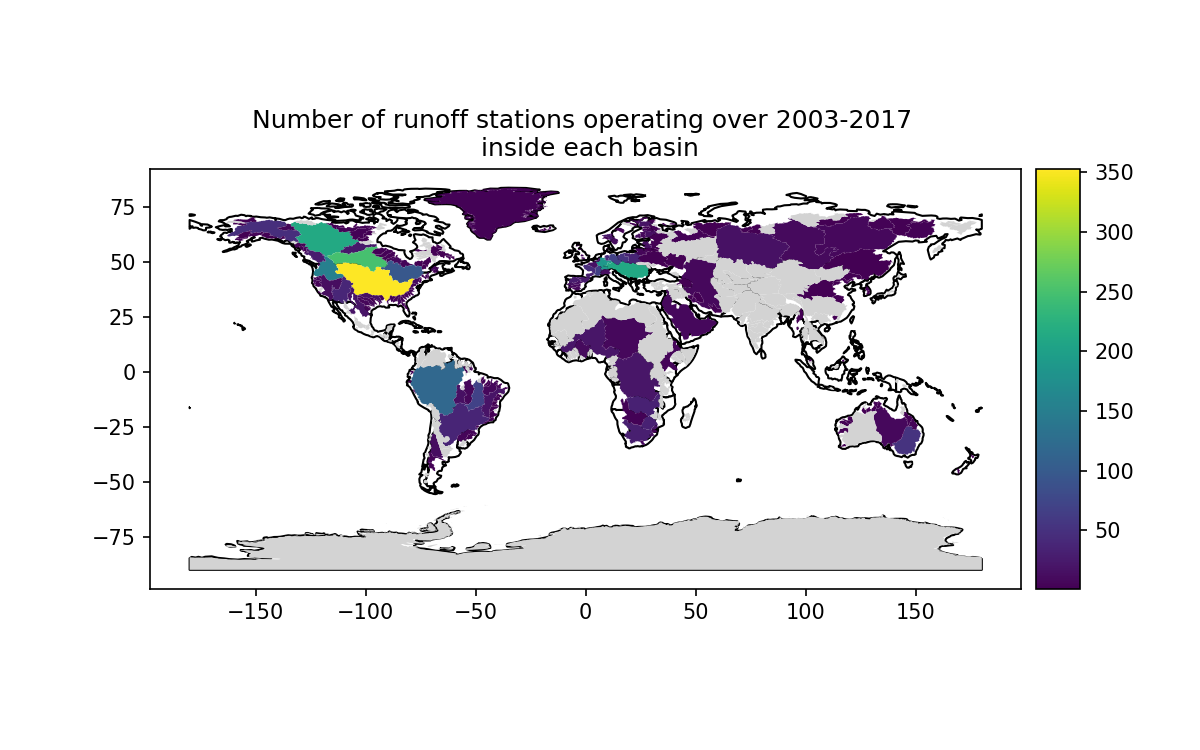

In [15]:
basins_plot=basins.copy()

basins_plot.loc[basins_plot['NB_RUNOFF']==0,'NB_RUNOFF']=np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
basins_plot.plot(ax=ax,column='NB_RUNOFF',legend=True,cax=cax,
            missing_kwds={"color": "lightgrey",},)
ax.set_title("Number of runoff stations operating over {}-{} \n inside each basin".format(year1,
                                                                                            year2,))
plt.show()

Save data

In [16]:
if approximate:
    basins.to_file("../datasets/basins/basins_with_approx_climate_zones_and_runoff_stations.shp")
else:
    basins.to_file("../datasets/basins/basins_with_climate_zones_and_runoff_stations.shp")